# Formalia:

Please read the [assignment overview page](https://github.com/SocialComplexityLab/socialgraphs2021/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday October the 31st, 2021 at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/


(If you haven't set up an account on peergrade yet, go to www.peergrade.io/join and type in the class code: ***DPZEV6***.)

### Overview

This year's Assignment 2 is all about analyzing the network of rappers.

Note that this time I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaningfully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----

## Individual contributions

- Andreas Stehle (ss220278): Part 2, 3
- Alexander Zimmer(s232002): Part 1
- Eper Stinner (s222955): Part 0, 4 

# Part 0: Building the network 

To create our network, we downloaded the rapper Wiki pages from each coast (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions.

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the rapper pages with the Wikipedia API.
> * Show the regular expressions you have built and explain in details how they work.

Required import statements for this exercise:

In [42]:
import re
import os
import requests
import urllib.request as request
import urllib.parse
import json
import pickle
import pandas as pd
import numpy as np

We first fetched the content of all rapper wikipedia pages and saved this data and the corresponding rapper for later use with `pickle`. From this point on we only have to read this data locally before further processing.

Next we moved on to the processing of the raw page content string. A regular expression was used to match the embedded wikipedia links in the raw page content string. Then we filtered the resulting ids to only include those of the rappers from `WestCoastRappers.csv` and `EastCoastRappers.csv` (or in this case simply `Rappers.csv`). Lastly we saved the resulting list of neighbouring nodes for each rapper in a list of enpoint pairs. Finally these edges were stored in a csv file for later use.

We used `pandas` dataframe representation to facilitate merging and filtering.

In [43]:
def download_article_revisions(article_name: str):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + urllib.parse.quote(article_name)
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)

    wikiresponse = request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    
    return json.dumps(json.loads(wikitext)["query"]["pages"])

In [44]:
# get list of rappers
df_rappers = pd.read_csv("./Rappers.csv")

# download page contents
list_pages = list()
for entry in df_rappers["WikipediaPageName"]:
    list_pages.append(download_article_revisions(entry))

# add page content to rapper dataframe
df_pages = df_rappers.copy()
df_pages["pagecontent"] = list_pages
# use the rapper names as an index for easier lookup
df_pages.set_index("WikipediaPageName", inplace=True)

In [45]:
# save rapper page content dataframe to pickle dump
with open('wikipedia_data_dump.pickle', 'wb') as wikipediafile:
    pickle.dump(df_pages, wikipediafile)

In [46]:
import pickle

# load rapper page content dataframe from pickle dump
df_pages = pd.read_pickle('wikipedia_data_dump.pickle')
df_pages.head()

,Coast,pagecontent
WikipediaPageName,,
6ix9ine,East,"{""55914767"": {""pageid"": 55914767, ""ns"": 0, ""ti..."
9th Prince,East,"{""2188910"": {""pageid"": 2188910, ""ns"": 0, ""titl..."
22Gz,East,"{""63102753"": {""pageid"": 63102753, ""ns"": 0, ""ti..."
38 Spesh,East,"{""57904572"": {""pageid"": 57904572, ""ns"": 0, ""ti..."
The 45 King,East,"{""1796123"": {""pageid"": 1796123, ""ns"": 0, ""titl..."


To find the neighbouring nodes for a rapper R we will scan the contents of R's wikipedia page for any links. The format of embedded links in wikipedia pages is predefined as follows: `[[link id | text]]`. We will then use the `wikilink_regex` regular expression to search for such strings. The components of the regular expression are as follows:
 - `.*` matches any character any number of times.
 - `?` guarantees that we match at least one character. `.*?` matches the entire contents between `[[` and `]]`.
 - In order to match the enclosing brackets as a string we have to escape them in the regular expression.

The completed regular expression is `\[\[.*?\]\]` and is used in the `find_wiki_ids` function below.

In [47]:
wikilink_regex = r'\[\[.*?\]\]'
df_rappers = pd.read_csv("./Rappers.csv")

def find_wiki_ids(pagestr):
    """
    Find all embedded wikipedia page ids in the page content

    Parameters:
        pagestr (string): raw page content string

    Returns:
        list of wikipedia page ids (string)
    """
    # retrieve embedded link strings
    internal_links = re.findall(wikilink_regex, pagestr)
    # print(internal_links)
    wikiIds = []
    # separate the link id from the optional text part
    for links in [id.split("|") for id in internal_links]:
        if len(links) > 1:
            wikiIds.append(links[0][2:])
        else:
            wikiIds.append(links[0][2:-2])
    return wikiIds

def get_connections(rapper):
    """
    Find all neighbouring rappers for a given rapper based on their wikipedia page

    Parameters:
        rapper (string): name of rapper
    
    Returns:
        a pandas dataframe containing the corresponding link endpoints (A, B), where A is the input rapper and B are the neighbours
    """
    # retrieve saved page content (with checks for artists on both coasts)
    wikistr = df_pages.loc[rapper].pagecontent
    # print(wikistr)
    if(isinstance(wikistr, pd.Series)):
        wikistr = wikistr[0]
    # create dataframe from wikipedia ids in rapper's page
    related = pd.DataFrame(find_wiki_ids(wikistr), columns=["Link"])
    # retrieve only links that are present in the rapper list
    rapper_neighbours = pd.merge(related, df_rappers, how='inner', left_on='Link', right_on='WikipediaPageName')
    # The A endpoint is always the input rapper
    # create dataframe of links where B is the list neighbouring rappers based on links present in the wiki page
    connections = pd.DataFrame({"A": [rapper for _ in range(len(rapper_neighbours.Link))], "B": rapper_neighbours.Link})
    return connections

# create initial dataframe
connections = pd.DataFrame(columns=["A", "B"])
for rapper in df_rappers.WikipediaPageName:
    # retrieve neighbours of rapper node
    partial = get_connections(rapper)
    # collect links in shared dataframe
    connections = pd.concat([connections, partial], axis=0)
    
connections.head()

/tmp/ipykernel_616/1496771268.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wikistr = wikistr[0]
/tmp/ipykernel_616/1496771268.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wikistr = wikistr[0]
/tmp/ipykernel_616/1496771268.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wikistr = wikistr[0]
/tmp/ipykernel_616/1496771268.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

,A,B
0,6ix9ine,Fetty Wap
1,6ix9ine,Fetty Wap
2,6ix9ine,ZillaKami
3,6ix9ine,ZillaKami
4,6ix9ine,Casanova (rapper)


In [48]:
# save the list of links for later use
connections.to_csv("./Rapper_links.csv", index=False)

# Part 1: Network visualization and basic stats

Visualize your network of rappers (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you have already generated the network and extracted the largest weakly connected component (the "largest weakly connected component" of a directed network is the subgraph consisting of the nodes that would constitute the largest connected component if the network were undirected) . The visualization and statistics should be done for the largest weakly connected component only.

_Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions to the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

First, a bit of additional data handling:

In [1]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def getcategorypages(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=1000"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    categories_list = wikitext_json["query"]["categorymembers"]

    return categories_list


def getwikidata(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    pages_content_list = wikitext_json["query"]["pages"]

    return pages_content_list

def parse_page(page, pages_list, graph):
    content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
    title = page["title"]

    # Normalize whitespace
    content = re.sub(r'[\n\t\ ]+', ' ', content)
    # retreive links
    links = re.findall('\[([^\]\[\|:]+)[\]\|]', content) # #! filter #
    filtered_links = np.unique(links)

    count = 0
    for link in filtered_links:
        if link in pages_list and not link == title:
            graph.add_edge(title, link)
            count += 1
    
    # Article word count
    word_count = len(re.findall('\w+', content.lower()))
    graph.nodes(data=True)[title]["word_count"] = word_count

    return count


cat_title_west = "Category:West Coast hip hop musicians"
cat_title_east = "Category:East Coast hip hop musicians"
pages_list_west = getcategorypages(cat_title_west)
pages_list_east = getcategorypages(cat_title_east)
rappers_list_west = [r["title"] for r in pages_list_west]
rappers_list_east = [r["title"] for r in pages_list_east]
rappers_list = rappers_list_east + rappers_list_west

# Graph
rappers_graph = nx.DiGraph()

for rapper in rappers_list:
    coast =  "east" if rapper in rappers_list_east else "west"
    rappers_graph.add_node(rapper, coast=coast, word_count=-1)

# Split list because of API limits
split_rappers_list = list(chunks(rappers_list, 50))

for sublist in split_rappers_list:
    titlestr = "|".join(sublist)
    pages_content_list = getwikidata(titlestr)
    result = [parse_page(page_content, rappers_list, rappers_graph) for key, page_content in pages_content_list.items()]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


-----

1a: Basic questions:

In [2]:
# Statistics

count_nodes = len(rappers_graph)
count_edges = len(rappers_graph.edges())

# Create degree statistic dicts
degrees = dict(rappers_graph.degree())
in_degrees = dict(rappers_graph.in_degree())
out_degrees = dict(rappers_graph.out_degree())

def find_top_5(stat_dict):
    degrees_west = []
    degrees_east = []
    top_overall = ""

    for rapper, degree in dict(sorted(stat_dict.items(), key=lambda item: item[1], reverse=True)).items():
        if top_overall == "":
            top_overall = rapper + " - " + str(degree)

        # dicts don't distinguish between east/west, so we'll do that here
        if len(degrees_west) < 5 and rapper in rappers_list_west:
            degrees_west.append(rapper + " - " + str(degree))
        elif len(degrees_east) < 5 and rapper in rappers_list_east:
            degrees_east.append(rapper + " - " + str(degree))

        if len(degrees_west) >= 5 and len(degrees_east) >= 5:
            break  # found all top 5
    
    return degrees_west, degrees_east, top_overall

top_5_in_west, top_5_in_east, top_in_overall = find_top_5(in_degrees)
top_5_out_west, top_5_out_east, top_out_overall = find_top_5(out_degrees)

print("Number of nodes: " + str(count_nodes))
print("Number of links: " + str(count_edges))

print()
print("Top-connected rappers (in-degree):")
print("> Overall:")
print(top_in_overall)
print("> West:")
print("\n".join(top_5_in_west))
print("> East:")
print("\n".join(top_5_in_east))

print()
print("Top-connected rappers (out-degree):")
print("> Overall:")
print(top_out_overall)
print("> West:")
print("\n".join(top_5_out_west))
print("> East:")
print("\n".join(top_5_out_east))

Number of nodes: 818
Number of links: 5856

Top-connected rappers (in-degree):
> Overall:
Snoop Dogg - 125
> West:
Snoop Dogg - 125
Dr. Dre - 81
Kendrick Lamar - 76
Tupac Shakur - 70
E-40 - 63
> East:
Jay-Z - 115
Nas - 97
50 Cent - 92
Busta Rhymes - 84
The Notorious B.I.G. - 63

Top-connected rappers (out-degree):
> Overall:
Drag-On - 52
> West:
DJ Dahi - 38
The Game (rapper) - 37
Kendrick Lamar - 37
Dr. Dre - 36
Kurupt - 35
> East:
Drag-On - 52
Black Thought - 42
Jahlil Beats - 35
MC Lyte - 35
Uncle Murda - 34


-----

1a: Distributions:

Exponents:
In-degrees: 1.6530363154116774
Out-degrees: 6.659069200448782


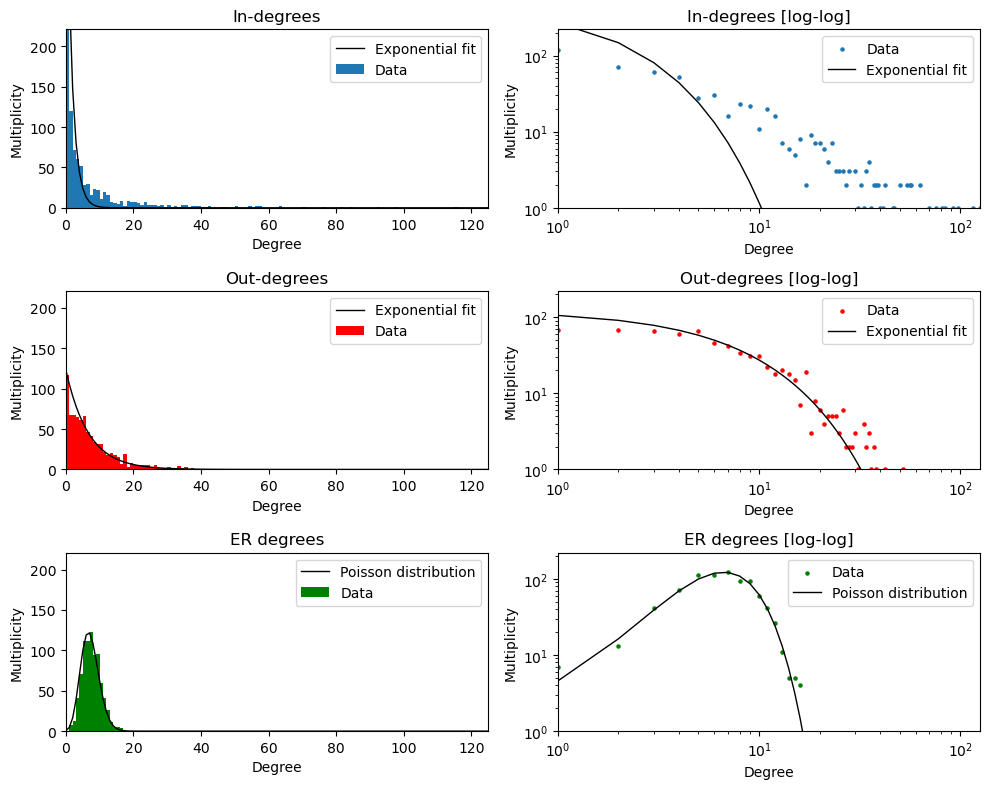

In [74]:
import pandas as p
import matplotlib.pyplot as plt
import powerlaw
from scipy.stats import expon, poisson


# Degree multiplicities
in_degrees_counts = p.Series(in_degrees.values()).value_counts()
out_degrees_counts = p.Series(out_degrees.values()).value_counts()

max_degree = max([max(in_degrees_counts.index), max(out_degrees_counts.index)])
max_multiplicity = max([max(in_degrees_counts.values), max(out_degrees_counts.values)])
range_x = range(max_degree + 1)

in_degrees_counts_interp = in_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()
out_degrees_counts_interp = out_degrees_counts.reindex(range(max_degree+1), fill_value=0).sort_index()

# Exponents
fit_in = powerlaw.Fit(in_degrees_counts.sort_index().values, discrete=True, verbose=False)
fit_out = powerlaw.Fit(out_degrees_counts.sort_index().values, discrete=True, verbose=False)

exp_in = fit_in.alpha
exp_out = fit_out.alpha

print("Exponents:")
print("In-degrees: " + str(exp_in))
print("Out-degrees: " + str(exp_out))

# Random Graph
er_graph = nx.gnp_random_graph(count_nodes, (count_edges/count_nodes)/(count_nodes-1)) # edges per node / nodes-1 = p
er_degrees = dict(er_graph.degree())
er_degrees_counts = p.Series(er_degrees.values()).value_counts()

# Plots
plt.rcParams['figure.figsize'] = [10, 8]  # global setting
fig, axs = plt.subplots(3, 2)

axs[0,0].bar(in_degrees_counts.index, in_degrees_counts.values, align='edge', width=1, label='Data')
axs[0,0].plot(range_x, expon.pdf(range_x, 0, exp_in) * count_nodes, 'k-', lw=1, label='Exponential fit')
axs[0,0].set_title('In-degrees')
axs[0,0].set_xlim(0, max_degree)
axs[0,0].set_ylim(0, max_multiplicity)
axs[0,0].legend()

axs[0,1].scatter(in_degrees_counts.index, in_degrees_counts.values, s=5, label='Data')
axs[0,1].plot(range_x, expon.pdf(range_x, 0, exp_in) * count_nodes, 'k-', lw=1, label='Exponential fit')
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[0,1].set_title('In-degrees [log-log]')
axs[0,1].set_xlim(1, max_degree)
axs[0,1].set_ylim(1, max_multiplicity)
axs[0,1].legend()

axs[1,0].bar(out_degrees_counts.index, out_degrees_counts.values, align='edge', width=1, label='Data', color="red")
axs[1,0].plot(range_x, expon.pdf(range_x, 0, exp_out) * count_nodes, 'k-', lw=1, label='Exponential fit')
axs[1,0].set_title('Out-degrees')
axs[1,0].set_xlim(0, max_degree)
axs[1,0].set_ylim(0, max_multiplicity)
axs[1,0].legend()

axs[1,1].scatter(out_degrees_counts.index, out_degrees_counts.values, s=5, label='Data', color="red")
axs[1,1].plot(range_x, expon.pdf(range_x, 0, exp_out) * count_nodes, 'k-', lw=1, label='Exponential fit')
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[1,1].set_title('Out-degrees [log-log]')
axs[1,1].set_xlim(1, max_degree)
axs[1,1].set_ylim(1, max_multiplicity)
axs[1,1].legend()

axs[2,0].bar(er_degrees_counts.index, er_degrees_counts.values, align='edge', width=1, label='Data', color="green")
axs[2,0].plot(range_x, poisson.pmf(range_x, (count_edges/count_nodes)) * count_nodes, 'k-', lw=1, label='Poisson distribution')
axs[2,0].set_title('ER degrees')
axs[2,0].set_xlim(0, max_degree)
axs[2,0].set_ylim(0, max_multiplicity)
axs[2,0].legend()

axs[2,1].scatter(er_degrees_counts.index, er_degrees_counts.values, s=5, label='Data', color="green")
axs[2,1].plot(range_x, poisson.pmf(range_x, (count_edges/count_nodes)) * count_nodes, 'k-', lw=1, label='Poisson distribution')
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
axs[2,1].set_title('ER degrees [log-log]')
axs[2,1].set_xlim(1, max_degree)
axs[2,1].set_ylim(1, max_multiplicity)
axs[2,1].legend()

for ax in axs.flat:
    ax.set(xlabel='Degree', ylabel='Multiplicity')

fig.tight_layout()

Some observations:

Both in- and out-degree distributions look like they are Exponential. This is in contrast to the ER network shown in the third row, which is based on a Poisson distribution.

The exponent for in-degrees in lower, leading to a distribution which is even more uneven than for the out-degrees. This can be explained by several rappers relating to more significant rappers, which do not pose enough of a significance to them to justify a link in the opposite direction. (This makes sense, as for example article length doesn't scale proportionally to the subjects significance).

-----

1b: Visualization:

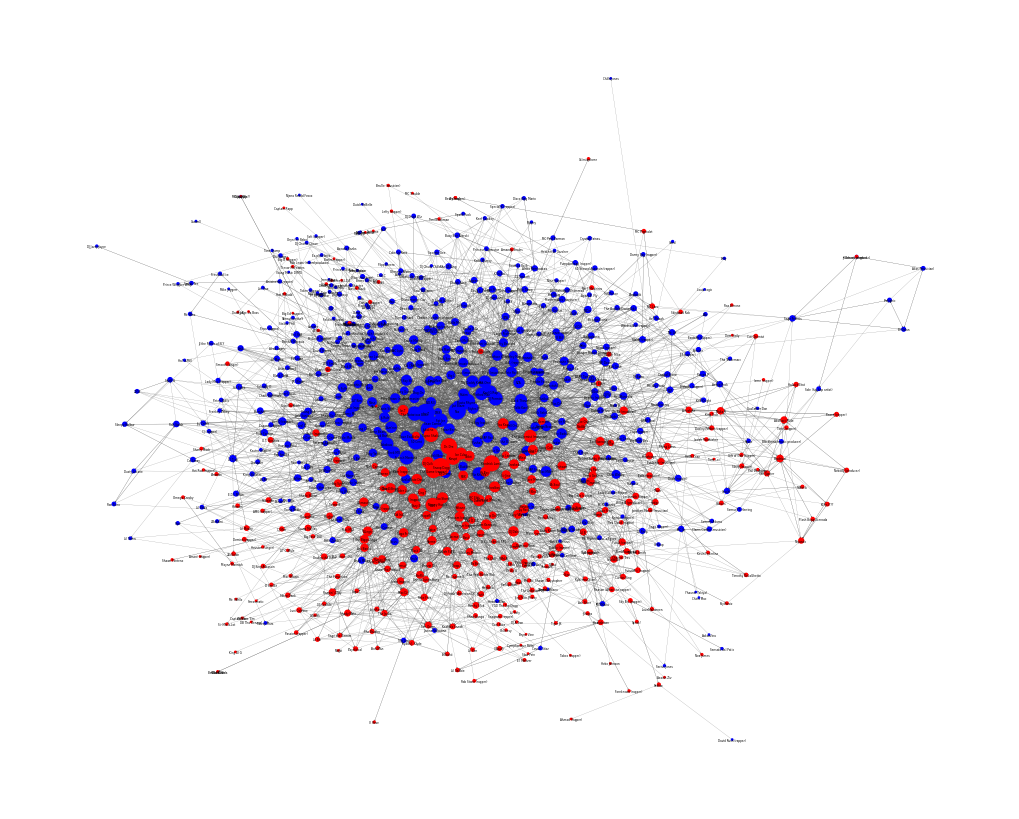

In [5]:
# Remove outliers
graph = rappers_graph.copy()
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Using graphviz for layout since nothing else really works well. Doesn't produce a circle, but you get the idea.
pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
coloreast = "#0000FF"
colorwest = "#FF0000"
node_colors = [coloreast if node[1]["coast"] == "east" else colorwest for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw_kamada_kawai(rsubgraph, with_labels=True, font_weight='light', font_size=2, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

We can observe two things from the graph:
- While being well interconnected, the coasts still form two significant clusters.
- Most connections stem from a few rappers, which are also responsible for most cost-to-coast connections.

-----

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from rappers' Wikipedia pages.

Here's what you need to do:
> * Create a word-cloud for each coast according to the novel TF-TR method. Feel free to make it as fancy as you like. Explain your process and comment on your results.
> * For each coast, what are the 5 words with the highest TR scores? Comment on your result.

Required imports for this exercise:

In [49]:
import pandas as pd
import re
import urllib.request as request
import urllib.parse
import numpy as np
import json
import os
import errno

## Fetch Wikipedia data for text mining

Because we use a different query to the Wikipedia API for text mining than for creating the rapper network, we will have to re-fetch all the rapper pages. The query used here tells the Wiki API to give us sanitized output, without links, markups, etc.

In [50]:
# collecting the wikipedia rapper pages for text analysis, storing the text content of each page
# in a file

# Folder structure:

# rapper_files
#   |- East     // contains files of east coast rappers
#   |- West     // contains files of west coast rappers

import pandas as pd
import re
import urllib.request as request
import urllib.parse
import numpy as np
import json
import os
import errno

def download_article_source(article_name: str):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = "titles=" + urllib.parse.quote_plus(article_name)
    content = "prop=extracts"
    exlimit = "exlimit=1"
    explaintext = "explaintext=1"
    dataformat ="format=json"

    query = "{}{}&{}&{}&{}&{}&{}".format(baseurl, action, content, exlimit, explaintext, dataformat, title)
    print(query)

    wikiresponse = request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')

    json.loads(wikitext)

    # page content
    for _, value in json.loads(wikitext)["query"]["pages"].items():
         return value["extract"]
    
extracts = list()
list_file_names = list()
df_rappers = pd.read_csv("./Rappers.csv")

def download_rappers_from_file(df_rappers):
    """
    Download all articles in the indicated file and store them in files for later use.

    Parameters:
        df_rappers (DataFrame): data frame read from the csv file provided
        root_folder_path (string): folder into which the rapper files should be written. 
        Folder structure will be created if it does not exist.
    """


    for row in df_rappers.iterrows():
        entry = row[1]["WikipediaPageName"]
        entry = entry.replace(" ", "_")
        filename = "./rapper_files/" + row[1]["Coast"] + "/" + entry+".txt"

        # create directories if they do not exist
        if not os.path.exists(os.path.dirname(filename)):
            try:
                os.makedirs(os.path.dirname(filename))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

        list_file_names.append(entry+".txt")
        with open(filename, "+w") as file:
            file.write(download_article_source(entry))

download_rappers_from_file(df_rappers)

https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=6ix9ine
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=9th_Prince
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=22Gz
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=38_Spesh
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=The_45_King
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=50_Cent
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=60_Second_Assassin_%28rapper%29
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlimit=1&explaintext=1&format=json&titles=88-Keys
https://en.wikipedia.org/w/api.php?action=query&prop=extracts&exlim

### Text preparation

Before we can create the word cloud, we have to process the raw wikipedia pages such that we can extract only 
relevant terms for our word clouds. This is because the wikipedia pages contain characters which are not words, and many words that occur frequently
but don't tell us a lot, e.g. stopwords. These words have low informational content, as they are contained in almost every text 
and thus, provide little meaning to this specific text.

The first step towards this goal is to split the text in each wikipedia page into words. This is done automatically by the PlainTextCorpusReader
which has rules on how to split a text into words. The specific rules can be read in their documentation.

Afterwards, we need to normalize the words, to be able to process words that have the same meaning but are written slightly 
differently. The following steps were taken: transform all words to lowercase, and stem the words. Stemming transforms words into its stem form, e.g.  plurals into singular form, past tense to infinitive, etc. For this process we use the WordNetLemmatizer from NLTK, as it will only proces words that are in it's dictionary, leading to less wrongly stemmed words.

In [51]:
# create text corpora and word frequency distributions for further work
import nltk.tokenize as tokenize
import nltk.corpus as corpus
import os
import nltk
wnl = nltk.WordNetLemmatizer()
from nltk.probability import FreqDist


# create corpora from downloaded sources, one for each coast
east_corpus = corpus.PlaintextCorpusReader("./rapper_files/East", os.listdir("./rapper_files/East"))
west_corpus = corpus.PlaintextCorpusReader("./rapper_files/West", os.listdir("./rapper_files/West"))


# extract words, exclude any non-alphanumeric characters (punctuations, etc.)
# and lemmatize words
east_words = [wnl.lemmatize(word.lower()) for word in east_corpus.words() if word.isalnum()]
west_words = [wnl.lemmatize(word.lower()) for word in west_corpus.words() if word.isalnum()]

### Generate weights to extract words for wordcloud

As mentioned above, many rather boring words appear often in texts. Therefore we cannot simply count and display the most common words in a text.
Therefore, use the approach TF-TR, which stands for Term-Frequency - Term Ratios. TF is the count how often a word appears in a text, TR is the ratio how often a term appears in one list versus how often it appears in the other list.

TF-TR is calculated for east and west coast word lists using the following formulae: 

$$w_{t}^{(w)} = \frac{\textrm{TF}^{(w)}_t}{ \textrm{TF}^{(e)}_t + c}, \qquad \textrm{and} \qquad w_{t}^{(e)} = \frac{\textrm{TF}^{(e)}_t}{ \textrm{TF}^{(w)}_t + c}, \qquad c > 0$$

whereas the supercripts $(e)$ indicates the east-coast and $(w)$ indicates west-coast. What TF-TR does, is it sets the amount of how often a word appears in a list of words in relation to how often it appears in another list of words. Thus, if a word appears often in one list, but rarely in the other, it will have a higher weight than words appearing often (or rarely) in both texts. The term c is used to adjust the weights (it devalues words that appear rarely) as well as making sure no division by 0 is possible. 

In [52]:
# create frequency distributions
fdist_east = FreqDist(east_words)
fdist_west = FreqDist(west_words)
most_common_east = fdist_east.most_common()
most_common_west = fdist_west.most_common()

# set c value described above
c = 50

#### create the TF-TR weights for each coast from the frequency distributions

# calculate TF-TR weights for east coast and sort the list such that highest weights are in the beginning
weighted_east = [(word, count / (fdist_west[word] + c)) for word, count in most_common_east]
weighted_east = sorted(weighted_east, key=lambda x: x[1], reverse=True)

# do the same for west coast
weighted_west = [(word, count / (fdist_east[word] + c)) for word, count in most_common_west]
weighted_west = sorted(weighted_west, key=lambda x: x[1], reverse=True)

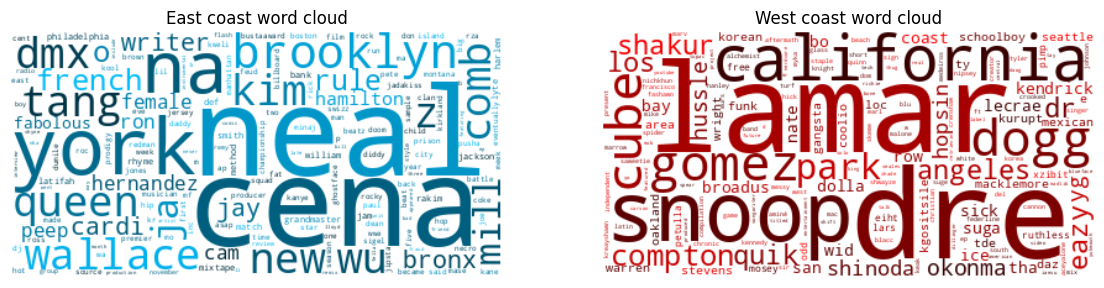

In [74]:
import wordcloud as wc
from wordcloud import WordCloud
from wordcloud import get_single_color_func
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cloud_text_east = str.join(" ", [word for word, counter in weighted_east for i in range (0, round(counter))])
cloud_text_west = str.join(" ", [word for word, counter in weighted_west for i in range (0, round(counter))])

def generate_wordcloud(fig, ax, text: str, colorfunc, title): 
    # to recreate colors: use color func described on this page: https://amueller.github.io/word_cloud/generated/wordcloud.get_single_color_func.html
    # and apply it as shown here: 
    wordcloud = WordCloud(collocations=False, background_color="white", max_font_size=100).generate(text)
    wordcloud = wordcloud.recolor(color_func=colorfunc)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

fig, ax = plt.subplots(1 , 2, sharex='col', sharey='row', figsize=(14, 14))

generate_wordcloud(fig, ax[0], cloud_text_east, get_single_color_func('deepskyblue'), "East coast word cloud")
generate_wordcloud(fig, ax[1], cloud_text_west, get_single_color_func('red'), "West coast word cloud")


**Image description:** Word clouds for east and west coast. Word weights were calculated using TF-TR. Blue word cloud represents words from the east coast, red word cloud from west coast.

In [54]:
print("Top 5 TR scores on east coast: ", weighted_east[:5])
print("Top 5 TR scores on west coast: ", weighted_west[:5])

Top 5 TR scores on east coast:  [('neal', 7.280701754385965), ('cena', 7.180327868852459), ('york', 6.033333333333333), ('na', 4.616161616161616), ('brooklyn', 4.590909090909091)]
Top 5 TR scores on west coast:  [('lamar', 4.326315789473684), ('dre', 3.5949367088607596), ('snoop', 3.4958677685950414), ('california', 3.3851851851851853), ('dogg', 3.1666666666666665)]


**Question:** For each coast, what are the 5 words with the highest TR scores? Comment on your result.

**Answer:** 

For the east coast the most common terms and their weight are:
- 'neal', 7.28
- 'cena', 7.18
- 'york', 6.03
- 'na', 4.61
- 'brooklyn', 4.59

For the west coast the most common terms and their weight are:
- 'lamar', 4.33
- 'dre', 3.59
- 'snoop', 3.49
- 'california', 3.39
- 'dogg', 3.17

These terms are predominantly parts of rapper names and places. The rapper names may be because the articles of these rappers are very long, and their names are often mentioned on them. Additionally, looking at the networks, these are also nodes with a very high degree. Thus, they are also often mentioned on other pages, but only within their community.

The places are also names and may be explained by many rappers having lived there or been influenced by the community in them. They are also unique to each coast.

Most common english words were filtered out by TF-TR as they often appear in both texts. This leaves terms unique to each coast, which in case of the wikipedia articles are mostly names.

# Part 3: Communities

Find communities and their modularity (from lecture 7).

Here's what you need to do:
> * In your own words, explain what the measure "modularity" is, and the intuition behind the formula you use to compute it. 
> * Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?
> * Comment on your results:
>   * How many communities did you find in total?
>   * Compute the value of modularity with the partition created by the algorithm.
>   * Plot and/or print the distribution of community sizes (whichever makes most sense). Comment on your result.
> * Now, partition your rappers into two communities based on which coast they represent.
>   * What is the modularity of this partition? Comment on the result.

**Question:** Explain the concept of modularity in your own words.

**Answer:** Modularity measures how tightly a group of nodes is connected together in comparison to how tightly a random network would be connected on average.

It is calculated by: 

$M_c = \frac{L_c}{L} - (\frac{k_c}{2L})^2$

which is the number of links within the local community divided by the total number of links in the network minus the square of the sum of degrees in the local community divided by 2 times the total number of links in the network. Therefore the first term calculates relative connectedness within the community compared to the network, the second term the connectedness of a random model squared.

In [55]:
connections = pd.read_csv("./Rapper_links.csv")
connections.head()

,A,B
0,6ix9ine,Fetty Wap
1,6ix9ine,Fetty Wap
2,6ix9ine,ZillaKami
3,6ix9ine,ZillaKami
4,6ix9ine,Casanova (rapper)


In [56]:
# create network from data 

import networkx as nx

G = nx.Graph()
G.add_nodes_from(df_rappers[df_rappers.Coast == "East"].WikipediaPageName, coast="east", color="red")
G.add_nodes_from(df_rappers[df_rappers.Coast == "West"].WikipediaPageName, coast="west", color="blue")
G.add_edges_from(connections.values)

G.remove_nodes_from([node for node in G.nodes if G.degree(node) < 1])

### Find communities in the network, and explain how you chose to identify the communities: Which algorithm did you use and how does it work?

To get the communuities, we used the louvain community detection method. This method tries to maximize the modularity of the partition it creates. The algorithm initially puts every node in a separate community, thus for $n$ nodes it creates $n$ communities.

Then, the algorithm repeatedly iterates through two phases until no further gain in modularity can be achieved:

1. Remove a node from it's own community and put the node into the community of each of it's neighbors. Calculate the gain in modularity for each community the node is put into. Put the node into the community where modularity is maximized. Do this for all $n$ nodes. Repeat until no more gains in modularity can be achieved.
2. For each new community, create a "meta node". Set the weight of the link between 2 "meta nodes" as the sum of all links between the nodes of the 2 communities the "meta nodes" represent. Replace the original network with the new "meta network". Goto step 1.

In [57]:
louvain_partition = nx.community.louvain_communities(G)

print( "number of communities found: ", len(louvain_partition))
print("modularity of louvain partitions: ", nx.community.modularity(G, louvain_partition))

number of communities found:  9
modularity of louvain partitions:  0.4171355984083257


### How many communities did you find in total?

The louvain algorithm is not deterministic. Therefore, running the algorithm several times, we get different result. We got between 9-11 communities. At the time of writing, the algorithm created 9 distributions.

### Compute the value of modularity with the partition created by the algorithm.

Modularities also change slightly. The modularity of the partiton found by the louvain algorithm at the time of writing is 0.4157.

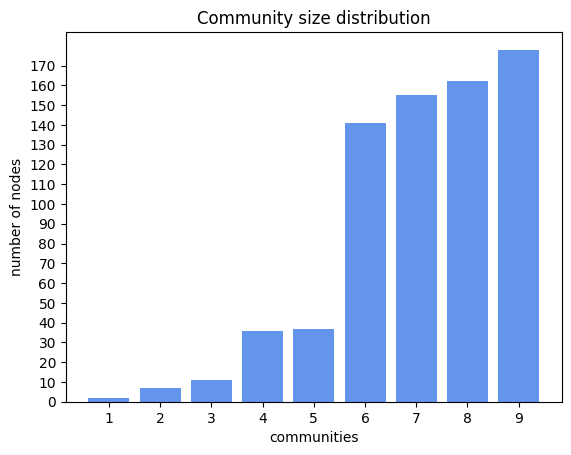

Size of each community printed:  [2, 7, 11, 36, 37, 141, 155, 162, 178]


In [58]:
import matplotlib.pyplot as plt

sorted_size_communities = sorted([len(comm) for comm in louvain_partition])

plt.bar(
    [x for x in range (1,len(louvain_partition)+1)], 
    sorted_size_communities,
    color="cornflowerblue"
)
plt.title("Community size distribution")
plt.xlabel("communities")
plt.ylabel("number of nodes")
plt.xticks([x for x in range (1,len(louvain_partition)+1)])
plt.yticks([i for i in range (0, sorted_size_communities[-1], 10)])
plt.show()

print("Size of each community printed: ", sorted_size_communities)

**Plot description:** Bar plot of the community size distribution. The y-axis shows the number of nodes in each distribution.

### Comment on community size distribution.

From the bar plot we can see that several very small communities exist, and several other ones that are significantly larger. The four smallest distributions are very similar in size to each othe, as are the four largest distributions. This shows that there exist some small, isolated groups of rappers in the network, that have more links among each other, than to the rest of the network, as well as larger groups with the same characteristic.

### Now, partition your rappers into two communities based on which coast they represent.

In [59]:
# getting east and west rapper names.

coast = nx.get_node_attributes(G, "coast")
nodes_east = [node for node in G.nodes if coast[node] == "east"]
nodes_west = [node for node in G.nodes if coast[node] == "west"]

# according to documentation community.modularity uses the same formula described above
print("East-west partition modularity", nx.community.modularity(G, [set(nodes_east), set(nodes_west)]))

East-west partition modularity 0.2505122130394858


### What is the modularity of this partition? Comment on the result.

The modularity of this partition is 0.25, which is much lower than the partition achieved by the louvain algorithm above. This reveals, that the east and west coast communities are not the "tightest" communities found in the graph, so there are more subgroups within the rapper-scene than just the split between east coast and west coast. One grouping of tighter communities was found using the Louvain algorithm above, with a modularity of 0.4157.

# Part 4: Sentiment of communities

Analyze the sentiment of communities (lecture 8). More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* Average the average sentiment of the nodes in each community to find a community-level sentiment.

Here's what you need to do (use the LabMT wordlist approach):
> * Calculate and store sentiment for every rapper
> * Create a histogram of all rappers' associated sentiments.
> * What are the 10 rappers with happiest and saddest pages?

Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.
> * Does the result make sense to you? Elaborate.



Required import statements for this exercise:

In [60]:
import numpy as np
from nltk import FreqDist
import pandas as pd
import string
import nltk.corpus as corpus
from nltk import word_tokenize, Text
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import math

### Calculate and store sentiment for every rapper

We begin by reading the labMT word list and the associated metrics into a `pandas` dataframe. To make later lookup easier we will use the `word` column as an index.

We also read the list of rappers from `Rappers.csv` into a `pandas` dataframe using `WikipediaPageName` as an index. 

In [61]:
labMT = pd.read_csv("./labMT.txt", sep="\t")
# to facilitate happiness_average value lookup
labMT.set_index("word", inplace=True)
labMT.head()

,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
word,,,,,,,
laughter,1,8.50,0.9313,3600,--,--,1728
happiness,2,8.44,0.9723,1853,2458,--,1230
love,3,8.42,1.1082,25,317,328,23
happy,4,8.30,0.9949,65,1372,1313,375
laughed,5,8.26,1.1572,3334,3542,--,2332


In [62]:
# Read the list of rappers
df_rappers = pd.read_csv("./Rappers.csv")
# index to facilitate coast lookup for each rapper
df_rappers.set_index("WikipediaPageName", inplace=True)
df_rappers.sort_index(inplace=True)
df_rappers.head()

,Coast
WikipediaPageName,
03 Greedo,West
22Gz,East
24kGoldn,West
38 Spesh,East
40 Glocc,West


Next we define the function `sentiment` to calculate the sentiment for a list of tokens (i.e. the text from a rapper's wikipedia page). If the list has a positive length we start by computing the frequency of each unique word using `FreqDist`.

Not all tokens from the wikipedia page might be present in the LabMT word list. Therefore we filter the list of unique words to obtain a vocabulary that we can evaluate for sentiment. We then compute sentiment on the vocabulary using the following formula (from [**Week 8 Video Lecture**](https://www.dropbox.com/scl/fi/u0rn767hg7e6ue4ryx41a/Sentiment.mp4?rlkey=4kwfqv6pkw1aijshm5zqe8ehh&dl=0)):
$$\frac{\sum_{w \in V}{f_w h_w}}{\sum_{w \in V} f_w}$$

where $w$ is a word from vocabulary $V$, $f_w$ is its frequency and $h_w$ is the associated average happiness value according to `labMT.txt`.

In [63]:
def sentiment(tokens):
    if(len(tokens) == 0):
        return
    freq = FreqDist(tokens)

    # filter for the vocabulary we can evaluate with LabMT
    vocab = list(filter(lambda word: word in labMT.index, np.unique(tokens)))

    # array of each token's average happiness weighted by the token's frequency
    weighted_happiness = np.fromiter((freq[word] * labMT.loc[word].happiness_average for word in vocab), dtype=float)
    # each token's frequency
    word_frequencies = np.fromiter((freq[word] for word in vocab), dtype=float)
    return np.sum(weighted_happiness) / np.sum(word_frequencies)

Next we will process the previously created rapper wikipedia files for sentiment analysis. We do this with the following steps:
 - tokenize raw wikipedia page text
 - filter out punctuation tokens using `string.punctuation`
 - convert token to lower case
 - lemmatize token using `WordNetLemmatizer` from `nltk.stem`

In [64]:
# mapping rapper names to file names
filenames = [f"{name.replace(' ', '_')}.txt" for name in df_rappers.index]
names_to_files = zip(df_rappers.index, filenames)

rapper_tokens = {}
wnl = WordNetLemmatizer()
for name, file in names_to_files:
    # fetch coast, with checks for artists on both coasts
    coast = None
    if(len(df_rappers.loc[name]) > 1):
        coast = df_rappers.loc[name].Coast[0]
    else:
        coast = df_rappers.loc[name].Coast
    # open and read individual rapper wikipedia page
    with open(f"./rapper_files/{coast}/{file}", "r") as fh:
        raw = fh.read()
        # tokenization and lemmatization of words (filtering out punctuation)
        tokens = list(filter(lambda token: wnl.lemmatize(token.lower()) not in string.punctuation, word_tokenize(raw)))
        rapper_tokens[name] = tokens


/tmp/ipykernel_616/1871944238.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coast = df_rappers.loc[name].Coast[0]


Next we compute the sentiment value of each preocessed text and collect the resulting values in the `sentiments` dictionnary. For easier access we then convert the obtained dictionnary to the `sentiments_df` dataframe.

In [65]:
sentiments = {}
for name in rapper_tokens.keys():
    # compute sentiment for individual rapper wiki page
    sentiment_value = sentiment(rapper_tokens[name])
    if(sentiment_value):
        sentiments[name] = sentiment_value

sentiments_df = pd.DataFrame({"rapper": sentiments.keys(), "page_happiness": sentiments.values()})
# use the rappers' name as index
sentiments_df.set_index("rapper", inplace=True)
sentiments_df.head()

,page_happiness
rapper,
03 Greedo,5.381573
22Gz,5.329292
24kGoldn,5.618791
38 Spesh,5.598146
40 Glocc,5.246625


### Create a histogram of all rappers' associated sentiments.

We first used `np.histogram` and Sturges' rule to sort the values into bins before plotting the result using `matplotlib`.
$$no. \ bins = 1 + \log_2(n)$$

where $n$ is the number of data points.

The result can be seen on the left sublot. The x axis shows the bin edge values while the y axis shows the number of pages in the corresponding range. We can see that the range of the distribution is not very significant. It also seems that the plot resembles a normal distribution. For this reason we can apply Scott's rule to find the bin width and use this to plot a more detailed view of the data (right subplot).

Scott's rule:
$$bin \ width=\frac{3.49 \sigma}{\sqrt[3]{n}}$$

On both histograms we can notice that the lower end of the distribution has slightly higher frequency values than the higher end of its range. This indicates that the rapper pages have a slight tendency towards negativity.

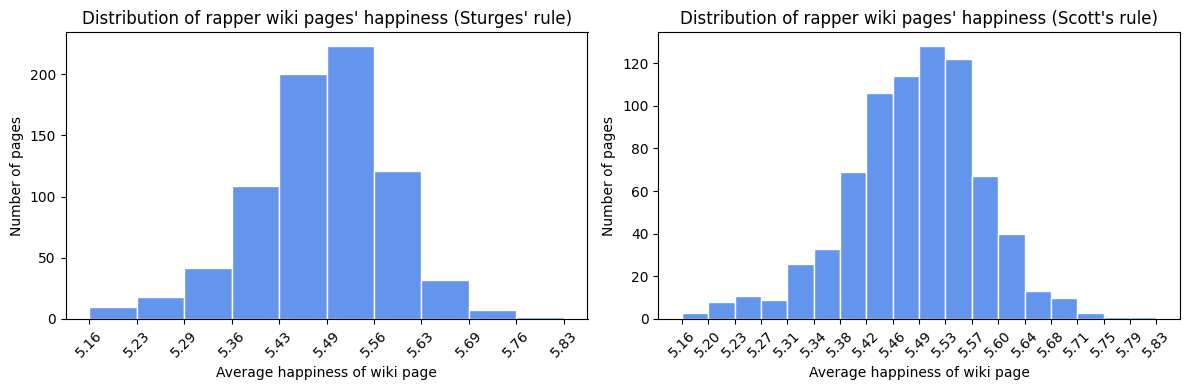

In [66]:
data = sentiments_df.page_happiness
# Sturges rule
no_bins_sturges = int(1 + math.log(len(data), 2))

# Scott's rule
data_range = np.max(data) - np.min(data)
bin_width = 3.49 * np.std(data) / (len(data) ** (1/3))
no_bins_scott = int(data_range / bin_width)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
bin_numbers = [no_bins_sturges, no_bins_scott]
titles = ["Distribution of rapper wiki pages' happiness (Sturges' rule)", "Distribution of rapper wiki pages' happiness (Scott's rule)"]

# plotting histograms
for idx, (no_bins, title) in enumerate(zip(bin_numbers, titles)):
    counts, bins = np.histogram(data, bins=no_bins)
    widths = bins[:-1] - bins[1:]
    hist, bin_edges, _ = ax[idx].hist(data, bins=no_bins, color="cornflowerblue", edgecolor='white')
    ax[idx].set_xticks(bin_edges)
    ax[idx].set_xticklabels(['%.2f' % val for val in bin_edges], rotation=45)
    ax[idx].set_title(label=title)
    ax[idx].set_xlabel(xlabel="Average happiness of wiki page")
    ax[idx].set_ylabel(ylabel="Number of pages")
plt.show()

**Plot description:** Histograms of the rapper page sentiment values with two binning methods: according to Sturges' rule (left) and according to Scott's rule (right)

In [67]:
print("LabMT minimum average word happiness: ", labMT.happiness_average.min())
print("LabMT maximum average word happiness: ", labMT.happiness_average.max())
print("LabMT mean average word happiness: ", labMT.happiness_average.mean())


LabMT minimum average word happiness:  1.3
LabMT maximum average word happiness:  8.5
LabMT mean average word happiness:  5.375239679123459


By looking at the minimal, maximal and mean happiness values from the LabMT word list, we can see that the overall happiness of the rapper wiki pages is average. This is to be expected as the text of wikipedia articles has a very factual style and an objective point of view.

### What are the 10 rappers with happiest and saddest pages?

We use `pandas` built in functionality to compute the happiest and saddest pages: first we sort by the average happiness of the page (`page_happiness` column), then we limit the result to 10 records.

As seen on the histogram, the maximum and the minimum average happiness values do not have a large difference.

In [68]:
print("Top 10 rappers with the happiest pages:")
sentiments_df.sort_values("page_happiness", ascending=False).head(10)

Top 10 rappers with the happiest pages:


,page_happiness
rapper,
Foreknown (rapper),5.825634
Theo Martins,5.779615
DJ Webstar,5.733636
D Smoke,5.723351
Blxst,5.715609
King Lil G,5.710247
MC Yogi,5.704872
Bkorn,5.704158
Bahamadia,5.703636


In [69]:
print("Top 10 rappers with the saddest pages:")
sentiments_df.sort_values("page_happiness", ascending=True).head(10)

Top 10 rappers with the saddest pages:


,page_happiness
rapper,
Cool C,5.159117
China Mac,5.162536
AR-Ab,5.180798
DJ Whoo Kid,5.200481
Benzino,5.201280
Drakeo the Ruler,5.204070
Half a Mill,5.206753
Shady Nate,5.210400
Jimmy Wopo,5.211556


### Now, compute the sentiment of each coast: 
> * Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0)).

We first filter the `df_rappers` dataframe by coast then retrieve the corresponding average happiness scores using an inner join on the rapper names in `sentiments_df`. Then we compute the mean of the resulting `page_happiness` column.

According to our calculations the happiest coast is the west coast, but there is only a slight difference.

In [70]:
# separating the rappers by coast
east_coast_view = df_rappers[df_rappers["Coast"] == "East"]
west_coast_view = df_rappers[df_rappers["Coast"] == "West"]

# inner join on the average happiness values
east_coast_happiness = sentiments_df.merge(east_coast_view, how="inner", left_on="rapper", right_on="WikipediaPageName")
west_coast_happiness = sentiments_df.merge(west_coast_view, how="inner", left_on="rapper", right_on="WikipediaPageName")

coasts = ["East", "West"]
for coast, dataset in zip(coasts, [east_coast_happiness, west_coast_happiness]):
    print(coast)
    print("Average sentiment: ", dataset.page_happiness.mean())
    print()

East
Average sentiment:  5.476669009758923

West
Average sentiment:  5.498466929906551



### Label shuffling test
> * Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

Previously we determined that the west coast seems to have a higher average page sentiment.
Now we will test this theory using label shuffling. Our null hypothesis will be that there is no significant difference between the sentiment of a random grouping and the sentiment of the west coast. We will be rejecting the hypothesis if less than 5% of the randomly roupings have a higher average happiness than that of the west coast.

In [77]:
# preparing the dataframe and original label distribution to test on 
labels = df_rappers.Coast.to_numpy()
df_rappers_test = df_rappers.copy()

# confidence bound
alpha = 0.05

# observed average page sentiment value
west_coast_happiness_mean = west_coast_happiness.page_happiness.mean()
# test 1000 random samples and collect the resulting average page sentiment
tests = []
for _iter in range(1000):
    # create random shuffle of labels
    df_rappers_test["Coast"] = np.random.permutation(labels)
    # filter for group of same size (marked by west coast label)
    random_west_coast_view = df_rappers_test[df_rappers_test["Coast"] == "West"]
    # retrieve page sentiment values and calcualte average
    test_happiness_mean = sentiments_df.merge(random_west_coast_view, how="inner", left_on="rapper", right_on="WikipediaPageName").page_happiness.mean()
    # save result
    tests.append(test_happiness_mean)

# computing the difference between the observed and the test sentiment
diff = west_coast_happiness_mean - np.array(tests)
# calculating the ratio of larger happiness values seen during testing 
p_value = 1 - np.sum(diff > 0)/len(diff)
if(p_value < alpha):
    print("Null hypothesis rejected.")
else:
    print("Null hypothesis sustained.")

Null hypothesis rejected.


### Does the result make sense to you? Elaborate.

We have rejected the null hypothesis, therefore there is a significant difference in average page happiness values for rappers from the west than from a randomly selected group of the same size. The reason could be associated with the geographical and cultural differences of the West Coast and East Coast. According to some [sources](https://www.businessinsider.com/top-15-happiest-cities-in-america-list-survey-2023-3?r=US&IR=T#6-irvine-ca-15) the happiest cities in the USA are on the west coast and especially in California. This might account for the difference. 

Another reason could be that either the wikipedia articles and/or the labMT wordlist may be biased towards words or slang used in relation with west coast rappers.